<a href="https://colab.research.google.com/github/Silver0x10/VideoPrediction_MovingMNIST/blob/main/notebooks/VideoPredictionMovingMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
setup_already_done = False

In [3]:
import sys
import os

In [4]:
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

True

In [5]:
if not setup_already_done:
    if(IN_COLAB):
        !git clone https://github.com/Silver0x10/VideoPrediction_MovingMNIST.git
        %cd VideoPrediction_MovingMNIST
    else:
        %cd ..
    if(not os.path.exists("data/mnist_test_seq.npy")):
        if(not os.path.exists("data")):
            %mkdir data
        %cd data
        !wget -q https://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy
        %cd ..

    %pip install -qr requirements.txt  --quiet
    setup_already_done = True

Cloning into 'VideoPrediction_MovingMNIST'...
remote: Enumerating objects: 554, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 554 (delta 24), reused 29 (delta 18), pack-reused 513
Receiving objects: 100% (554/554), 21.55 MiB | 8.97 MiB/s, done.
Resolving deltas: 100% (316/316), done.
/content/VideoPrediction_MovingMNIST
/content/VideoPrediction_MovingMNIST/data
/content/VideoPrediction_MovingMNIST
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 73.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 103.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 660.0/66

In [6]:
!nvidia-smi

Sun Sep 24 08:15:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pwd
# %cd VideoPrediction_MovingMNIST/

/content/VideoPrediction_MovingMNIST


In [7]:
import torch
from torch.utils.data import Dataset, DataLoader,random_split

import lightning.pytorch as pl
# from lightning.pytorch.loggers.wandb import WandbLogger
from lightning.pytorch.loggers import TensorBoardLogger, WandbLogger

import numpy as np

# import pylab as plt
import matplotlib.pyplot as plt

from src.utils import *

import wandb

In [8]:
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device.type

'cuda'

In [9]:
wandb.login(key='0deccf3c5bd58d99f264809d39253d25e0ae02fe')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Dataset

In [10]:
from src.MovingMNIST import MovingMNIST
from src.parameters import shared_params

In [11]:
dataset = MovingMNIST(data_path="data/mnist_test_seq.npy")

In [12]:
train_set, validation_set, test_set = random_split(dataset,[8000, 1000, 1000],
                                                   generator=torch.Generator().manual_seed(42))

## Reference Sample

In [59]:
sequence_test = test_set[42]
complete_sequence = torch.cat((sequence_test['frames'], sequence_test['y']))
dataset.visualize_given_frames_as_gif(complete_sequence)

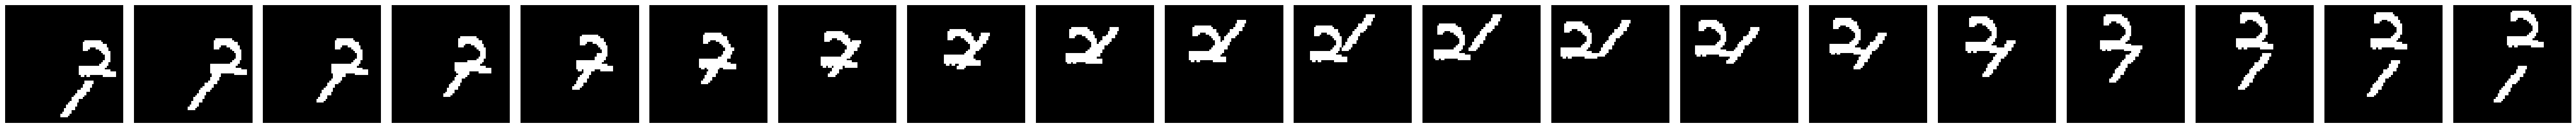

In [60]:
show_video_line(complete_sequence, 20)

In [61]:
print("Input:")
input_frames = sequence_test['frames']
dataset.visualize_given_frames_as_gif(input_frames)

Input:


In [62]:
print("Ground Truth:")
gt_frames = sequence_test['y']
dataset.visualize_given_frames_as_gif(gt_frames)

Ground Truth:


# 1) SimpleLSTM

In [ ]:
from src.simpleLSTM import SimpleLSTM
from src.parameters import ParamsSimpleLSTM

params_simpleLSTM = ParamsSimpleLSTM()
model_simpleLSTM = SimpleLSTM(params_simpleLSTM)

In [ ]:
params_simpleLSTM.training_epochs = 50
params_simpleLSTM.training_epochs

## Training + Testing

In [ ]:
training_dataloader = DataLoader(train_set, batch_size = params_simpleLSTM.batch_size)
validation_dataloader = DataLoader(validation_set, batch_size = params_simpleLSTM.batch_size)
test_dataloader = DataLoader(test_set, batch_size = params_simpleLSTM.batch_size)

In [ ]:
wandb_logger = WandbLogger(project='DeepLearning', name='SimpleLSTM_50epochs', log_model=True)

In [ ]:
wandb_logger.experiment.config['layers'] = str(model_simpleLSTM)

for p in vars(params_simpleLSTM).keys():
    wandb_logger.experiment.config[p] = vars(params_simpleLSTM)[p]

In [ ]:
trainer_simpleLSTM = pl.Trainer(max_epochs=params_simpleLSTM.training_epochs,
                                accelerator=device.type,
                                logger=wandb_logger,
                                # deterministic=True,
                                # fast_dev_run=1,
                                # overfit_batches=1, # to test if the model can learn
                                detect_anomaly=True)

In [ ]:
trainer_simpleLSTM.fit(model=model_simpleLSTM, train_dataloaders=training_dataloader, val_dataloaders=validation_dataloader)

In [ ]:
results_simpleLSTM = trainer_simpleLSTM.test(model_simpleLSTM, dataloaders=test_dataloader)

## Visualization Example

In [ ]:
# checkpoint_path = "lightning_logs/vo3td60s/checkpoints/epoch=9-step=80000.ckpt"
# # checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
# checkpoint = torch.load(checkpoint_path)
# model.load_state_dict(checkpoint['state_dict'])
# model.eval()

In [ ]:
print("Prediction:")
pred_simpleLSTM, _ = model_simpleLSTM(input_frames.unsqueeze(0))
pred_simpleLSTM = pred_simpleLSTM.detach().squeeze(0)
dataset.visualize_given_frames_as_gif(pred_simpleLSTM)

In [ ]:
fig, ax = plt.subplots(10, 3, figsize=(14, 28))
ax[0,0].set_title('Ground Truth')
ax[0,1].set_title('Prediction')
ax[0,2].set_title('Difference')

for i in range(gt_frames.shape[0]):
    gt_i = gt_frames[i, :, :]
    pred_i = pred_simpleLSTM[i, :, :]
    ax[i,0].imshow(gt_i, cmap='gray')
    ax[i,1].imshow(pred_i, cmap='gray')
    ax[i,2].imshow(gt_i - pred_i, cmap='gray')

fig.savefig('out/simpleLSTM_comparison.png')
wandb.log({"example": wandb.Image("out/simpleLSTM_comparison.png")})

fig.show()

## SimpleLSTM Finish

In [ ]:
wandb.finish()

In [ ]:
# !zip -r ../logs lightning_logs/ # Remember to save weights (if needed)

# 2) ConvLSTM

In [34]:
from src.ConvLSTM import *
from src.parameters import ParamsConvLSTM

params_convLSTM = ParamsConvLSTM()
model_convLSTM = EncoderDecoder(n_f= 32, n_ch= 1, k_sz= 5)#params_convLSTM.batch_size)

## Training + Testing

In [35]:
training_dataloader = DataLoader(train_set, batch_size = params_convLSTM.batch_size)
validation_dataloader = DataLoader(validation_set, batch_size = params_convLSTM.batch_size)
test_dataloader = DataLoader(test_set, batch_size = params_convLSTM.batch_size)

In [36]:
wandb_logger = WandbLogger(project='DeepLearning', name='ConvLSTM_TanH_ks5', log_model=True)

In [37]:
wandb_logger.experiment.config['layers'] = str(model_convLSTM)

for p in vars(params_convLSTM).keys():
    wandb_logger.experiment.config[p] = vars(params_convLSTM)[p]

In [38]:
trainer_convLSTM= pl.Trainer(max_epochs=params_convLSTM.training_epochs,
                             accelerator=device.type,
                             logger=wandb_logger,
                            #  deterministic=True,
                            #  fast_dev_run=1,
                            # overfit_batches=1, # to test if the model can learn
                            detect_anomaly=True)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [39]:
trainer_convLSTM.fit(model=model_convLSTM, train_dataloaders=training_dataloader, val_dataloaders=validation_dataloader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name    | Type         | Params
-----------------------------------------
0 | loss_fn | MSELoss      | 0     
1 | enc1    | ConvLSTMCell | 204 K 
2 | enc2    | ConvLSTMCell | 204 K 
3 | dec1    | ConvLSTMCell | 204 K 
4 | dec2    | ConvLSTMCell | 204 K 
5 | conv1   | Sequential   | 448   
6 | conv2   | Sequential   | 12.9 K
7 | deconv1 | Sequential   | 12.8 K
8 | deconv2 | Sequential   | 401   
-----------------------------------------
846 K     Trainable params
0         Non-trainable params
846 K     Total params
3.385     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name    | Type         | Params
-----------------------------------------
0 | loss_fn | MSELoss      | 0     
1 | enc1    | ConvLSTMCell | 204 K 
2 | enc2    | ConvLSTMCell | 204 K 
3 | dec1    | ConvLSTMCell | 204 K 
4 | dec2    | Conv

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [40]:
results_convLSTM = trainer_convLSTM.test(model_convLSTM, dataloaders=test_dataloader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    1659.3385009765625     │
└───────────────────────────┴───────────────────────────┘

## Reference Prediction:

In [ ]:
# Load weights if needed

# checkpoint_path = "lightning_logs/vo3td60s/checkpoints/epoch=9-step=80000.ckpt"
# # checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
# checkpoint = torch.load(checkpoint_path)
# model.load_state_dict(checkpoint['state_dict'])
# model.eval()

In [75]:
print("Prediction:")
pred_convLSTM = model_convLSTM(input_frames.unsqueeze(0).float())
pred_convLSTM = pred_convLSTM.detach().squeeze().cpu()
dataset.visualize_given_frames_as_gif(pred_convLSTM)


Prediction:


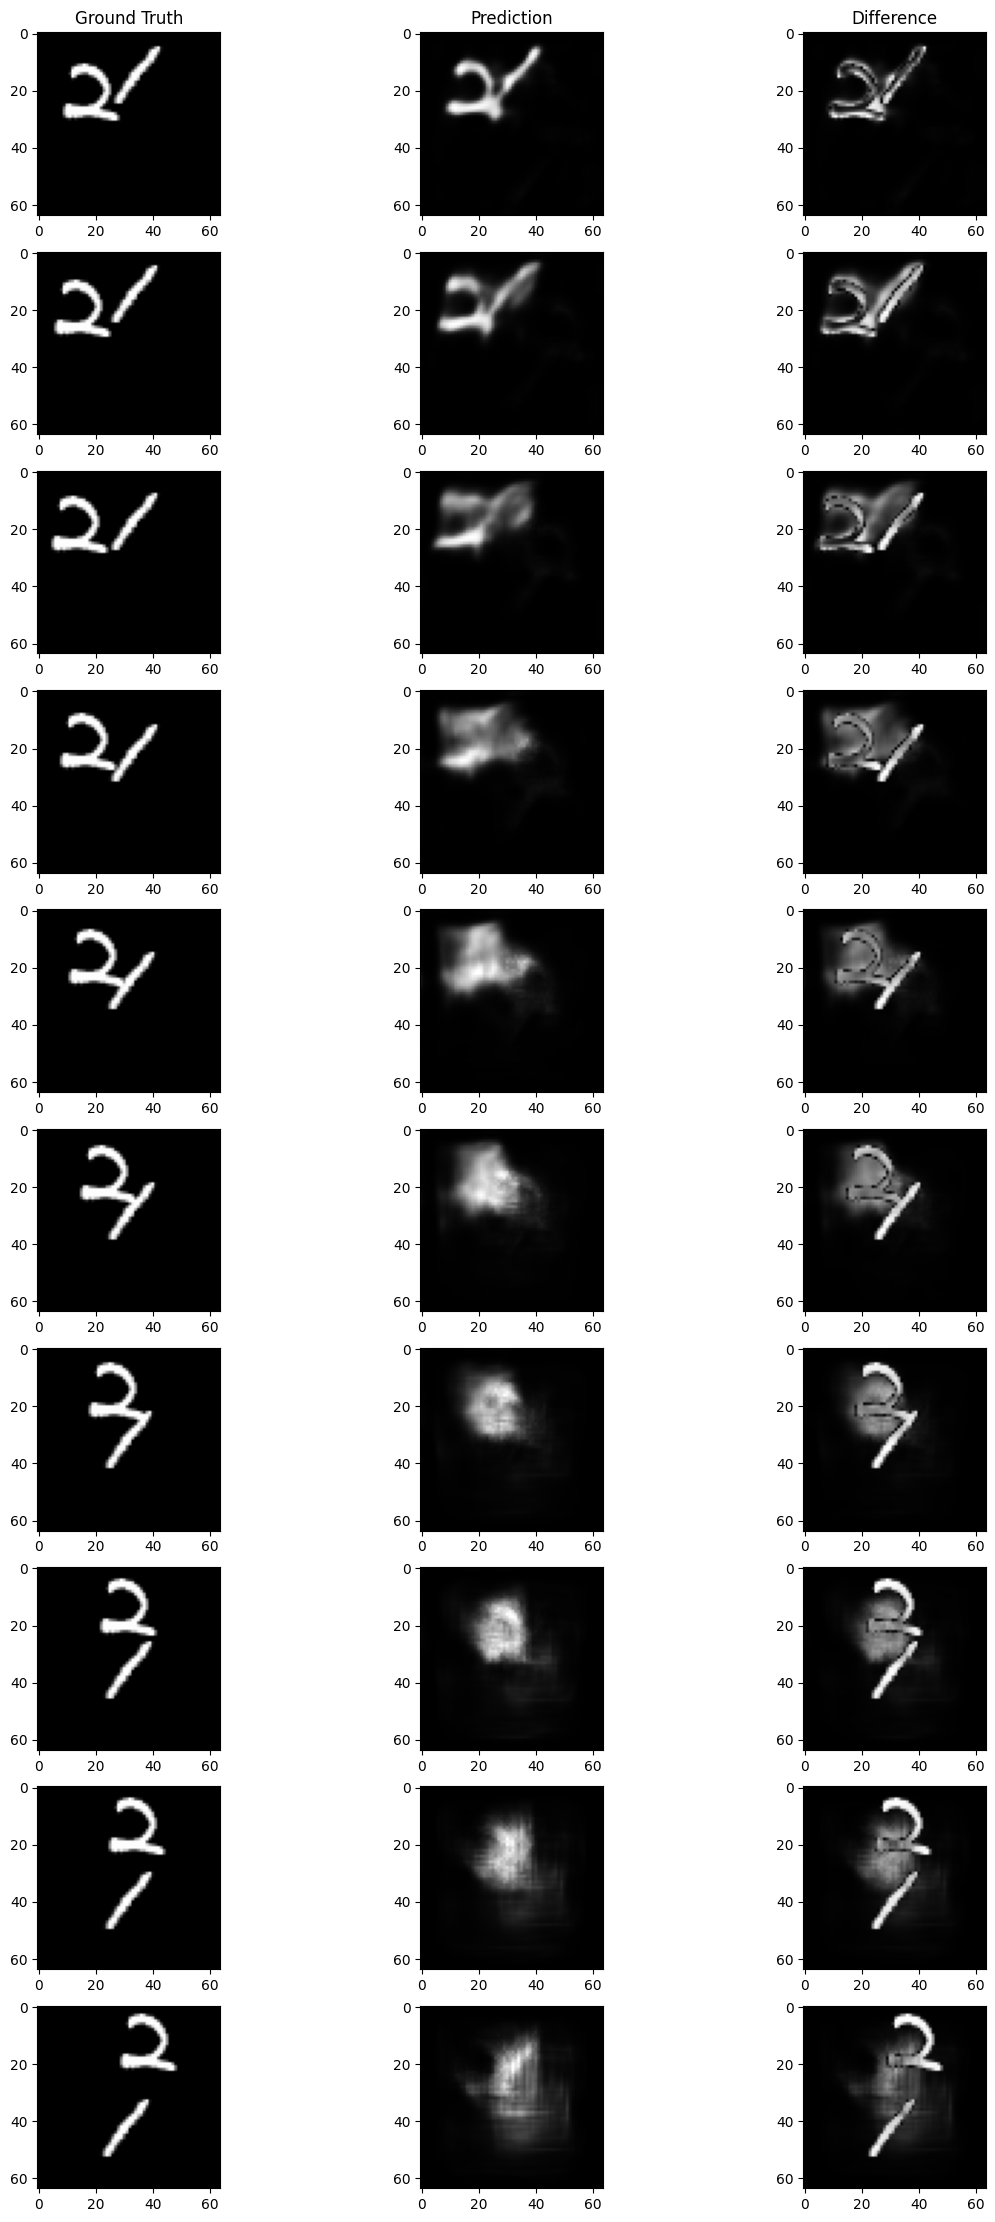

In [74]:
fig, ax = plt.subplots(10, 3, figsize=(14, 28))
ax[0,0].set_title('Ground Truth')
ax[0,1].set_title('Prediction')
ax[0,2].set_title('Difference')

for i in range(gt_frames.shape[0]):
    gt_i = gt_frames[i, :, :]
    pred_i = pred_convLSTM[i, :, :].cpu()
    picchio = gt_i - pred_i
    ax[i,0].imshow(gt_i, cmap='gray')
    ax[i,1].imshow(pred_i, cmap='gray')
    ax[i,2].imshow(abs(gt_i - pred_i), cmap='gray')

fig.savefig('out/convLSTM_comparison.png')
#wandb.log({"example": wandb.Image("out/convLSTM_comparison.png")})

fig.show()

## ConvLSTM Finish

In [52]:
torch.save(model_convLSTM.state_dict(), 'out/convLSTM_weights.pt')

In [49]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
mse_epoch,█▆▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
mse_step,█▇▇▆▆▅▅▅▅▄▅▃▄▃▄▃▄▃▄▂▃▂▃▂▃▂▂▂▁▂▁▂▁▂▁▂▁▂▁▁
test_loss,▁
train_loss_epoch,█▆▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
train_loss_step,█▇▇▆▆▅▅▅▅▄▅▃▄▃▄▃▄▃▄▂▃▂▃▂▃▂▂▂▁▂▁▂▁▂▁▂▁▂▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
validation_loss,██▅▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
epoch,20
mse_epoch,1537.20508
mse_step,1443.6936


In [51]:
!zip -r ../logs lightning_logs/ # Remember to save weights (if needed)

	zip warning: name not matched: lightning_logs/

zip error: Nothing to do! (try: zip -r ../logs . -i lightning_logs/)


# 3) ConvTAU

In [ ]:
from src.ConvTAU import ConvTAU
from src.parameters import params_ConvTAU

In [ ]:
params_ConvTAU['training_epochs'] = 50

In [ ]:
model_convTAU = ConvTAU(params_ConvTAU)

## Training + Testing

In [ ]:
batch_size = params_ConvTAU['batch_size']

training_dataloader = DataLoader(train_set, batch_size = batch_size)
validation_dataloader = DataLoader(validation_set, batch_size = batch_size)
test_dataloader = DataLoader(test_set, batch_size = batch_size)

In [ ]:
wandb_logger = WandbLogger(project='DeepLearning', name='ConvTAU_tuned', log_model=True)

wandb: Currently logged in as: silver_man (worst_dream_team). Use `wandb login --relogin` to force relogin


In [ ]:
wandb_logger.experiment.config['layers'] = str(model_convTAU)

for key in params_ConvTAU.keys():
    wandb_logger.experiment.config[key] = params_ConvTAU[key]
    print(key, ':', params_ConvTAU[key])

frames_per_sample : 10
channels : 1
frame_height : 64
frame_width : 64
in_shape : (10, 1, 64, 64)
hid_S : 32
hid_T : 128
N_S : 4
N_T : 8
mlp_ratio : 8.0
drop : 0.0
drop_path : 0.0
spatio_kernel_enc : 3
spatio_kernel_dec : 5
batch_size : 16
training_epochs : 50
learning_rate : 0.01
weight_decay : 0.05
kl_divergence_weight : 0.5


In [ ]:
trainer_convTAU = pl.Trainer(max_epochs=params_ConvTAU['training_epochs'],
                             accelerator=device.type,
                             logger=wandb_logger,
                            #  deterministic=True,
                            #  fast_dev_run=5,
                            #  overfit_batches=1, # to test if the model can learn
                             detect_anomaly=True)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer_convTAU.fit(model=model_convTAU, train_dataloaders=training_dataloader, val_dataloaders=validation_dataloader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name | Type       | Params
------------------------------------
0 | mse  | MSELoss    | 0     
1 | enc  | Encoder    | 28.3 K
2 | dec  | Decoder    | 256 K 
3 | hid  | MidMetaNet | 872 K 
------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.629     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name | Type       | Params
------------------------------------
0 | mse  | MSELoss    | 0     
1 | enc  | Encoder    | 28.3 K
2 | dec  | Decoder    | 256 K 
3 | hid  | MidMetaNet | 872 K 
------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.629     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


In [ ]:
results_convTAU = trainer_convTAU.test(model_convTAU, dataloaders=test_dataloader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_kl_loss        │   0.0027409789618104696   │
│         test_loss         │    1264.2735595703125     │
│       test_mse_loss       │    1264.2703857421875     │
└───────────────────────────┴───────────────────────────┘

## Visualization Example

In [ ]:
# checkpoint_path = "lightning_logs/vo3td60s/checkpoints/epoch=9-step=80000.ckpt"
# # checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
# checkpoint = torch.load(checkpoint_path)

# model_convTAU.load_state_dict(torch.load('out/convTAU_weights.pt'))
# model_convTAU.eval()


In [ ]:
print("Prediction:")
pred_convTAU = model_convTAU.single_prediction(input_frames).detach().squeeze(1)
dataset.visualize_given_frames_as_gif(pred_convTAU)

Prediction:


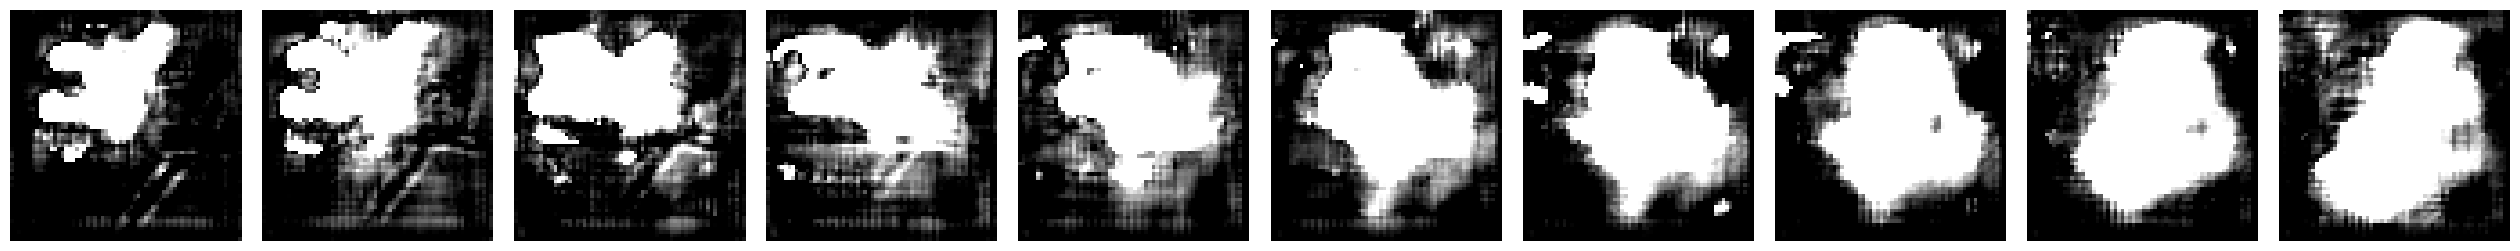

In [ ]:
show_video_line(pred_convTAU, 10)

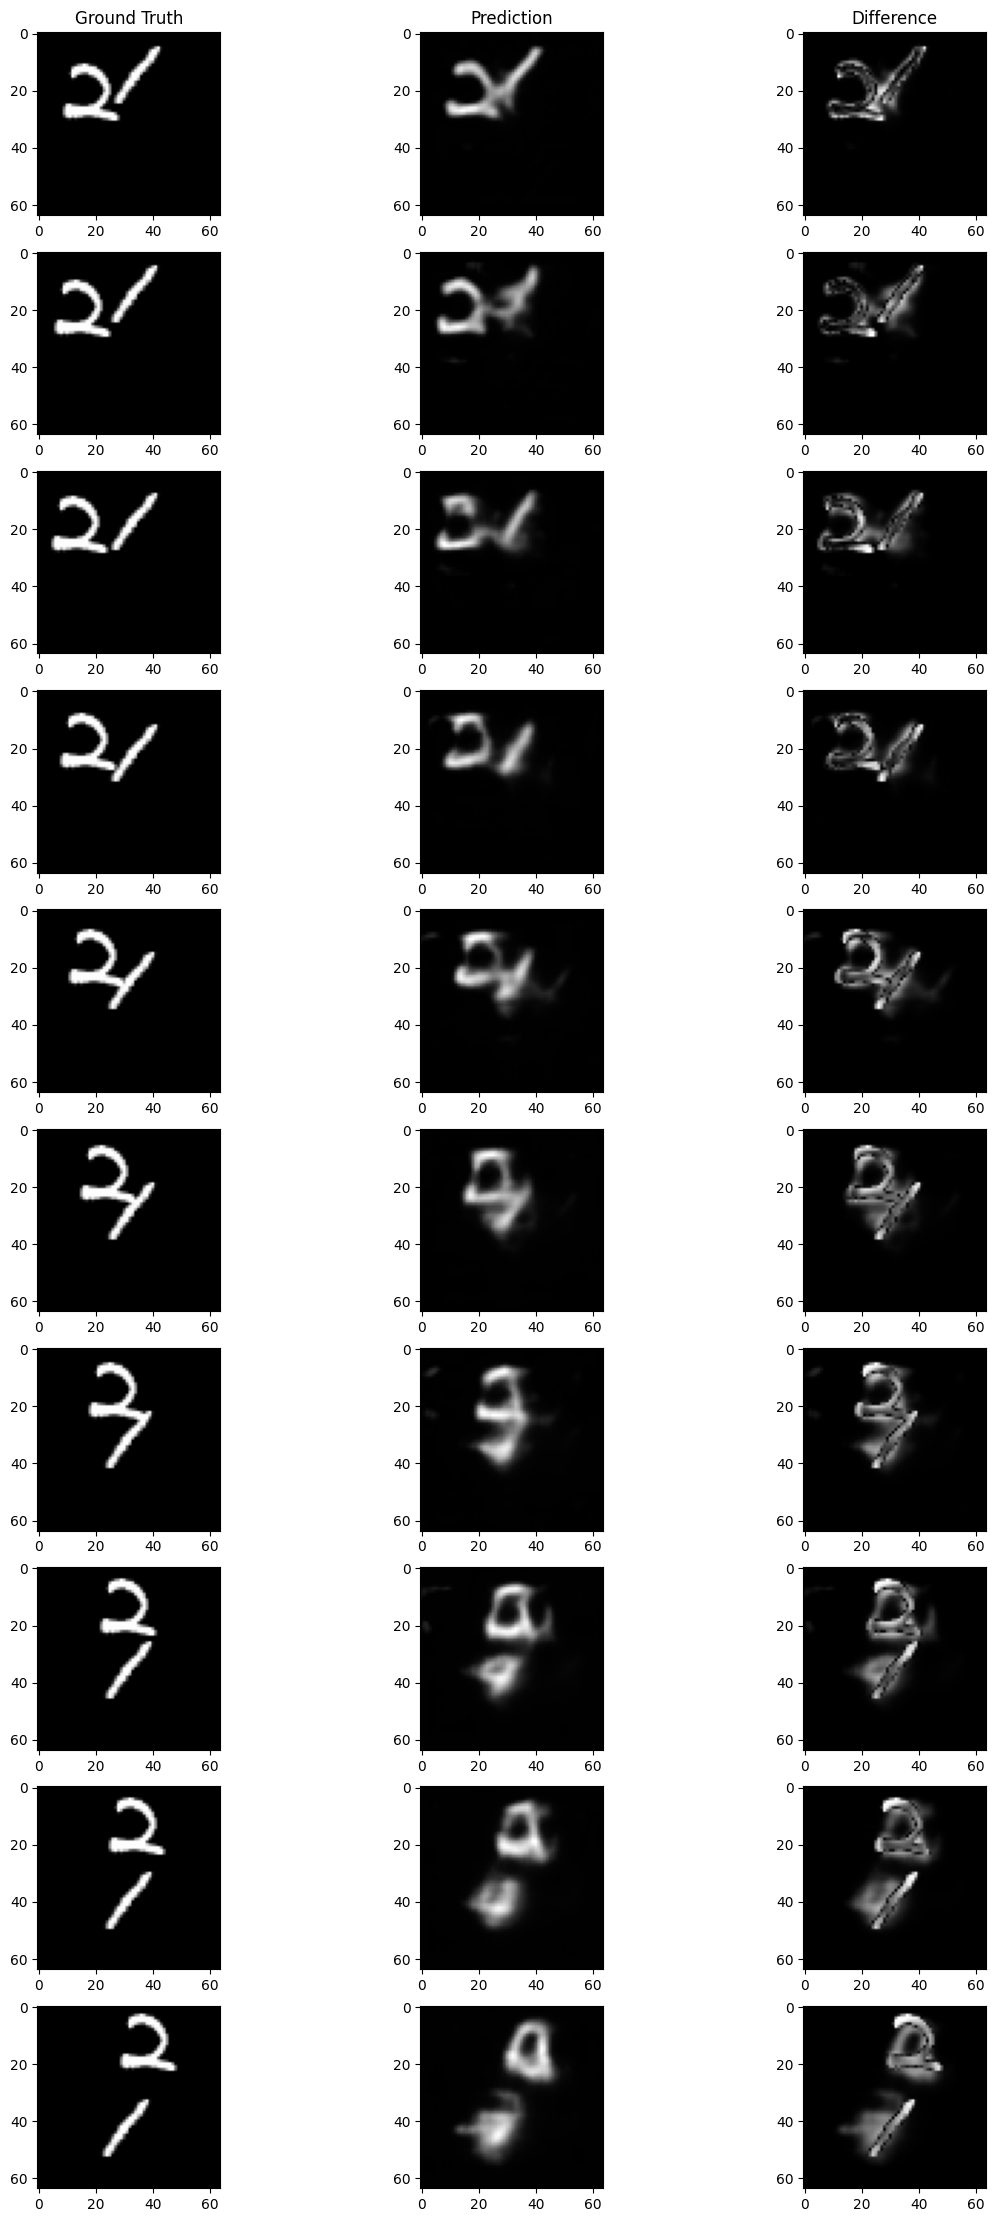

In [ ]:
fig, ax = plt.subplots(10, 3, figsize=(14, 28))
ax[0,0].set_title('Ground Truth')
ax[0,1].set_title('Prediction')
ax[0,2].set_title('Difference')

for i in range(gt_frames.shape[0]):
    gt_i = gt_frames[i, :, :]
    pred_i = pred_convTAU[i, :, :]
    ax[i,0].imshow(gt_i, cmap='gray')
    ax[i,1].imshow(pred_i, cmap='gray')
    ax[i,2].imshow(torch.abs(gt_i - pred_i), cmap='gray')

fig.savefig('out/convTAU_comparison.png')
wandb.log({"example": wandb.Image("out/convTAU_comparison.png")})

fig.show()

## ConvTAU Finish

In [ ]:
torch.save(model_convTAU.state_dict(), 'out/convTAU_weights.pt')

In [ ]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_kl_loss,▁
test_loss,▁
test_mse_loss,▁
train_kl_loss_epoch,█▇▆▆▅▄▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train_kl_loss_step,█▅▇▅▆▆▅▆▃▄▆▄▄▆▃▄▄▃▄▂▁▅▂▂▆▁▃▃▃▂▁▁▅▃▃▅▃▂▁▁
train_loss_epoch,█▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,█▇▇▅▆▄▄▅▃▃▄▃▃▃▃▄▂▂▄▂▂▃▂▂▂▂▃▁▂▃▁▁▂▂▁▂▁▃▁▂
train_mse_loss_epoch,█▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mse_loss_step,█▇▇▅▆▄▄▅▃▃▄▃▃▃▃▄▂▂▄▂▂▃▂▂▂▂▃▁▂▃▁▁▂▂▁▂▁▃▁▂
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


# Extra / Trash

In [ ]:
!zip -r ../out out/ # Remember to save/download weights and outputs (if needed)

  adding: out/ (stored 0%)
  adding: out/convLSTM_comparison.png (deflated 6%)
  adding: out/simpleLSTM_comparison.png (deflated 10%)
  adding: out/convTAU_weights.pt (deflated 8%)
  adding: out/convTAU_comparison.png (deflated 10%)
  adding: out/convTAU_hyperparams_tuning.txt (deflated 95%)


In [ ]:
# import gc
# print(torch.cuda.list_gpu_processes())
# gc.collect()
# torch.cuda.empty_cache()